# Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn.utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Loading Dataset

In [2]:
data =  pd.read_csv('AdSmartABdata.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,10/07/2020,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,07/07/2020,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,05/07/2020,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,03/07/2020,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,03/07/2020,15,Generic Smartphone,6,Chrome Mobile,0,0


# Preprocessing 
Categorical, numerical and timestamps columns

In [3]:
numerical = []
categorical = []
timestamps = []

for col in data.columns:
    if data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical.append(col)
    elif data[col].dtype == object:
        categorical.append(col)
    else:
        timestamps.append(col)
        
        
features = numerical+categorical+timestamps
raw = data[features]
raw.head(3)

,hour,platform_os,yes,no,auction_id,experiment,date,device_make,browser
0,8,6,0,0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,10/07/2020,Generic Smartphone,Chrome Mobile
1,10,6,0,0,000eabc5-17ce-4137-8efe-44734d914446,exposed,07/07/2020,Generic Smartphone,Chrome Mobile
2,2,6,0,1,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,05/07/2020,E5823,Chrome Mobile WebView


In [4]:
#checking missing value
raw.isna().sum()

hour           0
platform_os    0
yes            0
no             0
auction_id     0
experiment     0
date           0
device_make    0
browser        0
dtype: int64

All good no missing value in every column

# Variables Of Interest

We chose some variables(features) to be used for the analysis and they are experiment, device_make, browser columns together with Yes column wich is the target variable. Because we are interested in
knowing whether a user from a certain group(exposed/control) clicked Yes for ads.

In [5]:
#Taking our varibales of interest
raw_data = raw[['experiment','device_make','browser','yes']]
raw_data.head()

,experiment,device_make,browser,yes
0,exposed,Generic Smartphone,Chrome Mobile,0
1,exposed,Generic Smartphone,Chrome Mobile,0
2,exposed,E5823,Chrome Mobile WebView,0
3,control,Samsung SM-A705FN,Facebook,0
4,control,Generic Smartphone,Chrome Mobile,0


# Data Set Splitting

In [6]:
#Split the data into 70% training, 20% validation, and 10% test sets. 
def train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [36]:
train, validate, test = train_validate_test_split(raw_data)


In [7]:
#data spliting into training 90%, 10% for test set
from sklearn.model_selection import train_test_split

x = raw_data.drop(['yes'], axis = 1)
y = raw_data[['yes']]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .1, random_state = 0)
print('xtrain shape:', x_train.shape)
print('xtest shape:', x_test.shape)
print('ytrain shape:', y_train.shape)
print('ytest shape:', y_test.shape)

xtrain shape: (7269, 3)
xtest shape: (808, 3)
ytrain shape: (7269, 1)
ytest shape: (808, 1)


# Encoding Categorical Columns

Although OneHotEncoder is prefferable than label encoder, we will use labe encoder for computation limitation and memory 
allocation purpose.

In [8]:
#changing string columns to integers by using label encoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [9]:
xtrain_encoded = MultiColumnLabelEncoder(columns = ['experiment','device_make', 'browser']).fit_transform(x_train)

In [10]:
xtest_encoded = MultiColumnLabelEncoder(columns = ['experiment','device_make', 'browser']).fit_transform(x_test)

# Functions to measure the perfomance score and plots of actual and predicted values

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

In [29]:

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Observation')
    plt.ylabel('Choices')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

# Model 1 Logistic Regression

In [30]:
#training a logistic regression model
logreg = LogisticRegression()
logreg.fit(xtrain_encoded, y_train)

C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting the test set results and calculating the accuracy

In [13]:
#Predicting the test set results and calculating the accuracy
y_pred = logreg.predict(xtest_encoded)
print('Accuracy of logistic regression on test set: {:.2f}'.format(logreg.score(xtest_encoded, y_test)))

Accuracy of logistic regression on test set: 0.94


In [52]:
#Calculating the model perfomance
calculate_metrics(y_test, y_pred)

RMSE Score: 0.2487592975524973
R2_Squared: -0.06596306068601598
MAE Score: 0.06188118811881188


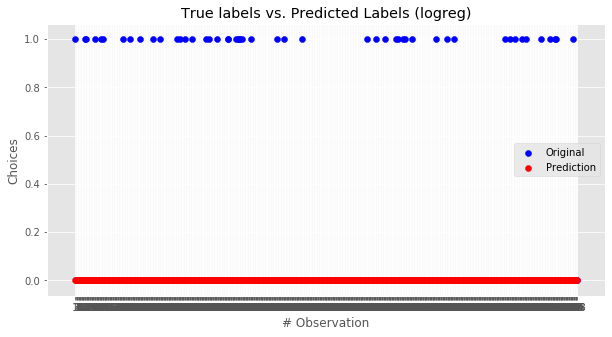

In [31]:
#prediction plots
plot_preds(y_test, y_pred, 'logreg')

# K-fold Cross Validation (Logistic Regression)

In k-fold cross-validation, the data is divided into k folds. The model is trained on k-1 folds with one fold held back for
testing. This process gets repeated to ensure each fold of the dataset gets the chance to be the held back set.

In [26]:
#5-fold cross validation
kfold = model_selection.KFold(n_splits=5, random_state=0)
results_kfold = model_selection.cross_val_score(logreg, xtrain_encoded, y_train, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeannette\anaconda3\lib\site-pack

Accuracy: 92.82%


C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeannette\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jeannette\anaconda3\lib\site-pack

# Feature Importance 

Logistic regression

Feature: 0, Score: 0.23065
Feature: 1, Score: -0.00125
Feature: 2, Score: 0.01816


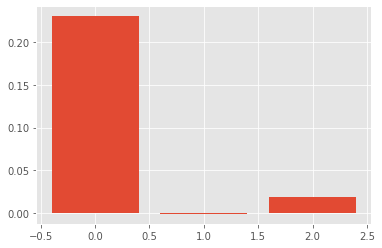

In [16]:
# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

From the above graph and feature importance computaion we can see that the features driving our logistic regression model 
are user experiment and the browser that the user uses. For that we can say that the feature leading to having more YES is 
the experiment feature.

# Model 2 Decision Tree

In [17]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(xtrain_encoded,y_train)

#Predict the response for test dataset
y_preds = clf.predict(xtest_encoded)

# Evaluating Model

In [55]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_preds))

Accuracy: 0.9022277227722773


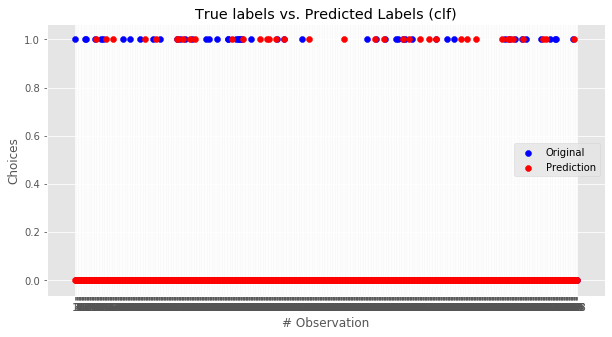

In [32]:
#prediction plots
plot_preds(y_test, y_preds, 'clf')

# Decision Tree Cross Validation

In [27]:
results_kfolds = model_selection.cross_val_score(clf, xtrain_encoded, y_train, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfolds.mean()*100.0)) 

Accuracy: 92.43%


we can see that the decision tree model is predicting the result with the accuracy of 92.43% while the logistic regression
has an accuracy of about 92.82% which makes the logistic regression a best model.

It is important to use k-fold cross validation rather than using the whole training set because it helps in ensuring that
the model perfoms well on new data and helps in selecting the best model, the parameters, and the accuracy metrics.


# Feature Importance

This helps in determining what is driving driving the model toward making good predictions.

Decion Tree Classifier

Feature: 0, Score: 0.07595
Feature: 1, Score: 0.72506
Feature: 2, Score: 0.19899


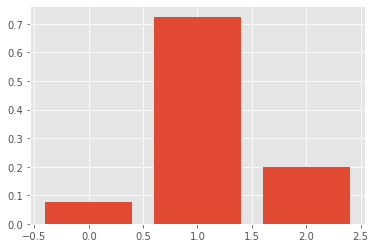

In [19]:
# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

From the above graph and feature importance computaion we can see that all features drives our decision tree classifier
model. However the feature leading to having more YES is the device that a user uses.